Azoacha Forcheh, 20558994

STAT 441: Classification

Assignment 1

In [310]:
from scipy.io import loadmat
from scipy.linalg import sqrtm

In [157]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
%matplotlib inline
import numpy as np
from numpy.linalg import norm

In [158]:
def plotimages(images, Y, scale=0.9, proportion=0.2):
    '''
    Input:
        images: images, must be in a 3-dimensional matrix (x by y by n)
            e.g. if X is 64 by 400 and size of each image is 8 by 8, 
            images=np.reshape(X,(8,8,400));
        Y: coordinates of where to plot the image (Y(1,:) by Y(2,:)
        scale: scale of each image wrt to figure size (scale <= 1, e.g. 0.8)
        proportion: proportion of the data to be ploted (proportion <= 1)
            e.g. if there are 400 data points proportion = 1, plots
            all 400 data points and proportion = 0.5 plot only 200 data points 
            (i.e. 1th, 3th, 5th, ...)
    Ali Ghodsi 2006
    '''
    Y /= norm(Y, axis = 1, ord=2).reshape((Y.shape[0],1))
    inc = np.floor(1/proportion)
    
    image_width = images.shape[0]
    image_height = images.shape[1] 
    n_images = images.shape[2]
    
    plt.gray()
    fig = plt.gcf()
    fig.clf()
    ax = plt.subplot(111)
    ax.set_xlim((Y[0,:].min()*1.2,Y[0,:].max()*1.2))
    ax.set_ylim((Y[1,:].min()*1.2,Y[1,:].max()*1.2))
    
    for counter in np.arange(0,n_images,inc):
        counter = int(counter)
        xy = (Y[0,counter],Y[1,counter])
        current_image = 1-np.reshape(images[:,:,counter], 
                                     (image_width,image_height))
        imagebox = OffsetImage(current_image, zoom=scale)
        ab = AnnotationBbox(imagebox, xy, xybox=(1., -1.), xycoords='data', 
                            boxcoords="offset points", frameon=False)                                  
        ax.add_artist(ab)
        plt.draw()
    #plt.show()

### Part (a)

In [43]:
X = loadmat('0_1_2.mat')['X']
(d, n) = X.shape

In [44]:
mu = np.mean(X, axis=1).reshape(d, 1)
X_mean = np.dot(mu, np.ones((1, n)))
X_tilde = X - X_mean

In [45]:
U, S, V = np.linalg.svd(X_tilde)
pcps = np.transpose(U[:, 0:2])
Y_pca = np.dot(pcps, X_tilde)

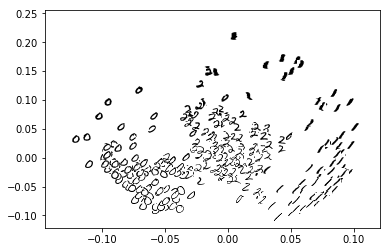

In [46]:
images = np.reshape(X,(8,8,n))
plotimages(images, Y_pca, 1, 1)
plt.show()

### Part (b)

In [47]:
S_w = np.zeros((d, d))

for i in range(1,4):
    k = i*100
    j = k - 100
    X_i = X[:, j:k]
    mu_i = np.mean(X_i, axis=1).reshape(d, 1)
    mean_i = np.dot(mu_i, np.ones((1, 100)))
    X_i = X_i - mean_i
    S_w = S_w + np.dot(X_i, np.transpose(X_i))

In [48]:
S_t = np.dot(X_tilde, np.transpose(X_tilde))/n
S_b =  S_t - S_w
M = np.dot(np.linalg.inv(S_w), S_b)
E, W = np.linalg.eig(M)

In [49]:
discrims = np.transpose(W[:, 0:2])
Y_fda = np.dot(discrims, X)

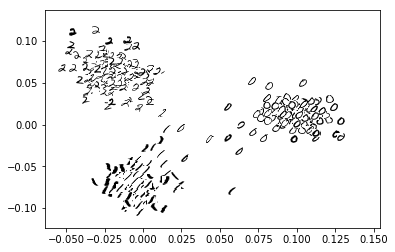

In [50]:
# using images = np.reshape(X,(8,8,n)) run above
plotimages(images, Y_fda, 1, 1)
plt.show()

### Part (c)

In [277]:
def summary_values(data, k):
    '''
    data: the dataset
    k: the number of classes in the dataset
    Assumes that there are m*k data points in the dataset,
        where m is a positive integer, with the next i*k 
        data points being from class i
    '''
    means = []
    covars = []
    (dim, npoints) = data.shape
    ppc = npoints/k # the number of points per class
    for i in range(1,k+1):
        # get the class mean
        b = i*ppc
        a = b - ppc
        data_i = data[:, a:b]
        mu_i = np.mean(data_i, axis=1).reshape(dim, 1)
        means.append(mu_i)
        
        # calculate the within class covariance
        mean_i = np.dot(mu_i, np.ones((1, ppc)))
        data_i = data_i - mean_i
        sigma_i = np.dot(data_i, np.transpose(data_i))/(ppc - dim)
        covars.append(sigma_i)  
    return (means, covars)

class_means, class_covars = summary_values(Y_pca, 3)

In [283]:
# Linear boundaries
sigma = sum(class_covars) 
xcoeffs = [np.dot(np.linalg.inv(sigma), mu) for mu in class_means]
consts = []
for i in range(len(slopes)):
    intercept = 0 - np.log(3) - (np.dot(
        np.transpose(class_means[i]), xcoeffs[i])/2)
    consts.append(intercept[0][0])
    
slopes = [xcoeffs[1]-xcoeffs[0], 
          xcoeffs[1]-xcoeffs[2], 
          xcoeffs[2]-xcoeffs[0]]
intercepts = [consts[1]-consts[0], 
              consts[1]-consts[2], 
              consts[2]-consts[0]]

In [284]:
# Quadratic boundaries
dets = [np.linalg.det(sig) for sig in class_covars]
mean_sig = []

for i in range(3):
    c = np.dot(np.linalg.inv(class_covars[i]), class_means[i])
    mean_sig.append(c)

# constant terms
a0 = [0]*3
a0[0] = (np.log(dets[1]) - np.log(dets[0]) +
          np.dot(np.transpose(class_means[1]), mean_sig[1]) -
          np.dot(np.transpose(class_means[0]), mean_sig[0]))
a0[1] = (np.log(dets[1]) - np.log(dets[2]) +
          np.dot(np.transpose(class_means[1]), mean_sig[1]) -
          np.dot(np.transpose(class_means[2]), mean_sig[2]))
a0[2] = (np.log(dets[2]) - np.log(dets[0]) +
          np.dot(np.transpose(class_means[2]), mean_sig[2]) -
          np.dot(np.transpose(class_means[0]), mean_sig[0]))
a0 = [-0.5*elem[0][0] for elem in a0]

# x coefficients
a1 = [0]*3
a1[0] = mean_sig[1] - mean_sig[0]
a1[1] = mean_sig[1] - mean_sig[2]
a1[2] = mean_sig[2] - mean_sig[0]

# x^2 coefficients
a2 = [0]*3
a2[0] = -0.5*(class_covars[1] - class_covars[0])
a2[1] = -0.5*(class_covars[1] - class_covars[2])
a2[2] = -0.5*(class_covars[2] - class_covars[0])

In [367]:
print("The formulas for the linear decision boundaries are:")
for i in range(3):
    formula = "   0 = y^T*[{},{}]^T %+f"
    print(formula.format(slopes[i][0][0], slopes[i][1][0]) % 
          intercepts[i])

The formulas for the linear decision boundaries are:
   0 = y^T*[62.3646802321,9.46174639799]^T +0.079522
   0 = y^T*[29.6954023751,1.86377382065]^T -0.946712
   0 = y^T*[32.669277857,7.59797257734]^T +1.026235


The formulas for the quadratic boundaries are:

$$
0 = {\bf y}^{T} \begin{bmatrix}
                          -5.46437767e-05 & 4.18409303e-04\\
                          4.18409303e-04 & -1.94088829e-03\\
                       \end{bmatrix} {\bf y} + {\bf y}^{T} \begin{bmatrix}
                                                              154.87505264\\
                                                              24.61722339\\
                                                           \end{bmatrix} -0.47397694
$$  

$$
0 = {\bf y}^{T} \begin{bmatrix}
                          -0.00027197 & 0.00040752\\
                          0.00040752 & -0.00221845\\
                       \end{bmatrix} {\bf y} + {\bf y}^{T} \begin{bmatrix}
                                                              75.19771341\\
                                                              0.95073167\\
                                                           \end{bmatrix} -3.40368554
$$

$$
0 = {\bf y}^{T} \begin{bmatrix}
                                2.17323021e-04 & 1.08933396e-05\\
                                1.08933396e-05 & 2.77564444e-04\\
                       \end{bmatrix} {\bf y} + {\bf y}^{T} \begin{bmatrix}
                                                              79.67733923\\
                                                              23.66649172\\
                                                           \end{bmatrix} + 2.929708601
$$

### Part (d)

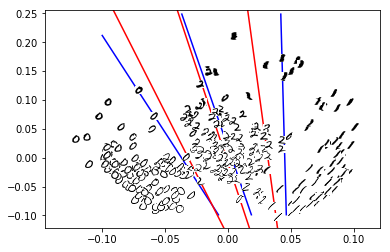

In [296]:
# using images = np.reshape(X,(8,8,n)) from above
plotimages(images, Y_pca, 1, 1)

x_min, x_max = -0.10, 0.10

# Linear Coefficients
xm1 = slopes[0][0][0]
ym1 = slopes[0][1][0]
xm2 = slopes[1][0][0]
ym2 = slopes[1][1][0]
xm3 = slopes[2][0][0]
ym3 = slopes[2][1][0]

c1 = intercepts[0]
c2 = intercepts[1]
c3 = intercepts[2]

lx = np.linspace(x_min, x_max)
lin_y1 = ((-1*lx*xm1) - c1)/ym1
lin_y2 = ((-1*lx*xm2) - c2)/ym2
lin_y3 = ((-1*lx*xm3) - c3)/ym3

plt.plot(lx, lin_y1, color = 'red') 
plt.plot(lx, lin_y2, color = 'red') 
plt.plot(lx, lin_y3, color = 'red')

# Quadratic Coefficients
ax1 = np.sum(a2[0][0])
ay1 = np.sum(a2[0][1])
b1 = np.sum(a2[0])
cx1 = a1[0][0][0]
cy1 = a1[0][1][0]
d1 = a0[0]

ax2 = np.sum(a2[1][0])
ay2 = np.sum(a2[1][1])
b2 = np.sum(a2[1])
cx2 = a1[1][0][0]
cy2 = a1[1][1][0]
d2 = a0[1]

ax3 = np.sum(a2[2][0])
ay3 = np.sum(a2[2][1])
b3 = np.sum(a2[2])
cx3 = a1[2][0][0]
cy3 = a1[2][1][0]
d3 = a0[2]

y_min, y_max = -0.10, 0.25 
y_range = np.linspace(y_min, y_max)

x, y = np.meshgrid(x_range, y_range)

plt.contour(x, y,
            (ax1*x*x)+(ay1*y*y)+(b1*x*y)+(cx1*x)+(cy1*y)+d1, 
            [0], colors = 'blue')
plt.contour(x, y,
            (ax2*x*x)+(ay2*y*y)+(b2*x*y)+(cx2*x)+(cy2*y)+d2, 
            [0], colors = 'blue')
plt.contour(x, y,
            (ax3*x*x)+(ay3*y*y)+(b3*x*y)+(cx3*x)+(cy3*y)+d3, 
            [0], colors = 'blue')

plt.show()

### Part (e)

In [364]:
def euclidean_lda(data, means):
    (d, n) = data.shape
    U, S, V = np.linalg.svd(data)
    S = np.diag(S)
    T = np.dot(np.linalg.inv(sqrtm(S)), np.transpose(U))
    X_hat = np.dot(T, data)
    X_mus = [np.dot(T, mu) for mu in means]
    
    Y = [0]*n
    for i in range(n):
        dist0 = np.dot(np.transpose(X_hat[:, i] - X_mus[0]),
                       X_hat[:,i] - X_mus[0])[0][0]
        dist1 = np.dot(np.transpose(X_hat[:,i] - X_mus[1]),
                       X_hat[:,i] - X_mus[1])[0][0]
        dist2 = np.dot(np.transpose(X_hat[:,i] - X_mus[2]),
                       X_hat[:,i] - X_mus[2])[0][0]
        
        if dist0 <= dist1 and dist0 <= dist2:
            Y[i] = 0
        elif dist1 <= dist0 and dist0 <= dist1:
            Y[i] = 1
        else:
            Y[i] = 2
    return Y

In [365]:
# Error rates
X_class_means = []
for i in range(1,4):
    b = i*100
    a = b - 100
    data_i = X[:, a:b]
    mu_i = np.mean(data_i, axis=1).reshape(d, 1)
    X_class_means.append(mu_i)
    
Y_lda = euclidean_lda(X, X_class_means)

In [369]:
Y_wrong = 0
for i in range(n):
    if i < 100:
        if Y_lda[i] != 0:
            Y_wrong = Y_wrong + 1
    elif i < 200:
        if Y_lda[i] != 1:
            Y_wrong = Y_wrong + 1
    else:
        if Y_lda[i] != 2:
            Y_wrong = Y_wrong + 1
            
L_n = Y_wrong/float(n)
print("The empirical error rate for the LDA is: {0:.000f}%."
      .format(L_n))

The empirical error rate for the LDA is: 1%.


### Part (f)

Yes, we can. We estimate some vector ${\bf w}$ such that ${\bf y} = {\bf w}^T{\bf x}$, where ${\bf w}$ is a d-by-1 column vector. In this case, we let ${\bf w}$ be the principals calculated via PCA.

We take the quadratic function that we are unable to estimate, which is ${\bf y} = {\bf x}^T{\bf v}{\bf x} + {\bf w}^T{\bf x}$. Then, extend ${\bf w}$ and the data ${\bf x}$ and by the square of values to $\hat{\bf x}$, as shown below:

$$
\begin{array}{rcl}
\hat{\bf w} &=& [w_1, w_2, ..., w_d, v_1, ..., v_d]\\
\hat{\bf x} &=& [x_1, x_2, ..., x_d, x_1^{2}, ..., x_d^{2}]
\end{array}
$$

This projects the data into two more dimensions, making it quadratic. We can then apply LDA to estimate the new function $\hat{\bf y}^* = \hat{\bf w}^T\hat{\bf x}$, since it is linear in $\hat{\bf x}$.